In [93]:
import glob
import json

examples = glob.glob("/plancraft/outputs/oracle_symb/*/0/*.json")
non_valid_ids = set()

for example in examples:
    data = json.load(open(example))
    if not data["success"]:
        non_valid_ids.add(data["example_id"])

print(len(non_valid_ids))

103


In [97]:
for dataset_name in glob.glob("data/*.json"):
    dataset = json.load(open(dataset_name))
    new_dataset = []
    for example in dataset:
        if example["id"] not in non_valid_ids:
            new_dataset.append(example)
    print(dataset_name, len(dataset), len(new_dataset))
    # replace
    json.dump(new_dataset, open(dataset_name, "w"), indent=2)

data/test.json 600 580
data/val.json 600 570
data/val.small.easy.json 100 100
data/train.json 1200 1147
data/test.small.json 120 117
data/val.small.json 120 110
data/test.small.easy.json 100 100


### Download outputs from wandb

In [77]:
import wandb
from tqdm import tqdm

project = "plancraft"
entity = "itl"

api = wandb.Api()
runs = api.runs(f"{entity}/{project}")

# download all 
for run in tqdm(runs):
    for file in run.files():
        if (
            file.name.startswith("outputs/")
            and file.name.endswith(".json")
            and "/val.small/" in file.name
            and "stp80" not in file.name
        ):
            file.download(exist_ok=True)

100%|██████████| 164/164 [03:21<00:00,  1.23s/it]


### Collate outputs into single results

In [141]:
import glob
import json

# load from local
task_results = glob.glob("outputs/*/val.small/*/*.json")
results = []

for task_result in task_results:
    example_id = task_result.split("/")[-1]
    seed = task_result.split("/")[-2]
    split = task_result.split("/")[-3]
    run_name = task_result.split("/")[-4]
    with open(task_result) as f:
        result = json.load(f)

    result["name"] = run_name
    result["split"] = split
    result["seed"] = seed

    results.append(result)

In [146]:
import pandas as pd

df = pd.DataFrame(results)
# df.model_trace.apply(pd.Series)
df = pd.concat([df, df.model_trace.apply(pd.Series)], axis=1).drop(
    "model_trace", axis=1
)
df = df[~df.example_id.isin(non_valid_ids)]

df["name"] = df["name"].str.replace("_Meta-Llama-3.1-8B-Instruct", "")
df["name"] = df["name"].str.replace("_symb", "")
df["tools"] = df["name"].str.split("_").str[-1]
df["mode"] = df["name"].str.split("_").str[0]

In [147]:
df.groupby(["name"]).tokens_used.sum() / 1000000 / 3 * 0.15

name
act_move|smelt                               61.758259
act_move|smelt|think                         96.632393
act_move|smelt|think|search                  82.943473
act_move|smelt|think|search|impossible       40.520209
oracle                                        0.000000
react_move|smelt                            126.184620
react_move|smelt|think                      131.344576
react_move|smelt|think|search               139.631777
react_move|smelt|think|search|impossible     77.132472
Name: tokens_used, dtype: float64

### Results Table for Success

In [148]:
df_pivot = (
    df.groupby(["name", "recipe_type"]).success.mean().unstack(level=1).reset_index()
)
df_pivot["overall"] = df_pivot[["mixed", "shaped", "shapeless", "smelting"]].mean(axis=1)

df_pivot["tools"] = df_pivot["name"].str.split("_").str[-1]
df_pivot["mode"] = df_pivot["name"].str.split("_").str[0]

df_pivot["model"] = "Llama 3.1 8B"
print(df_pivot[["model", "mode", "tools", "mixed", "shaped", "shapeless", "smelting", "overall", "impossible"]].to_latex(
    index=False, float_format="%.2f"
))


\begin{tabular}{lllrrrrrr}
\toprule
model & mode & tools & mixed & shaped & shapeless & smelting & overall & impossible \\
\midrule
Llama 3.1 8B & act & move|smelt & 0.05 & 0.01 & 0.18 & 0.33 & 0.14 & 0.00 \\
Llama 3.1 8B & act & move|smelt|think & 0.05 & 0.05 & 0.22 & 0.20 & 0.13 & 0.00 \\
Llama 3.1 8B & act & move|smelt|think|search & 0.09 & 0.40 & 0.51 & 0.87 & 0.47 & 0.00 \\
Llama 3.1 8B & act & move|smelt|think|search|impossible & 0.04 & 0.29 & 0.37 & 0.87 & 0.39 & 0.93 \\
Llama 3.1 8B & oracle & oracle & 1.00 & 1.00 & 1.00 & 1.00 & 1.00 & 1.00 \\
Llama 3.1 8B & react & move|smelt & 0.01 & 0.04 & 0.22 & 0.33 & 0.15 & 0.00 \\
Llama 3.1 8B & react & move|smelt|think & 0.03 & 0.05 & 0.24 & 0.33 & 0.16 & 0.00 \\
Llama 3.1 8B & react & move|smelt|think|search & 0.05 & 0.12 & 0.37 & 0.67 & 0.30 & 0.00 \\
Llama 3.1 8B & react & move|smelt|think|search|impossible & 0.01 & 0.11 & 0.27 & 0.60 & 0.25 & 0.73 \\
\bottomrule
\end{tabular}



### Results Table for Plan Length

In [170]:
id_to_steps = df[df["mode"] == "oracle"][["example_id", "number_of_steps"]].set_index("example_id").to_dict()["number_of_steps"]
# calculate steps diff between oracle and model
df["oracle_steps"] = df["example_id"].map(id_to_steps)
df["steps_diff"] = df["number_of_steps"] - df["oracle_steps"]
df.loc[~df["success"], "steps_diff"] = 10

In [172]:
df_pivot = (
    df
    .groupby(["name", "recipe_type"])
    .steps_diff.mean()
    .unstack(level=1)
    .reset_index()
)
df_pivot["overall"] = df_pivot[["mixed", "shaped", "shapeless", "smelting"]].mean(axis=1)
df_pivot["tools"] = df_pivot["name"].str.split("_").str[-1]
df_pivot["mode"] = df_pivot["name"].str.split("_").str[0]
df_pivot["model"] = "Llama 3.1 8B"
print(df_pivot[["model", "mode", "tools", "mixed", "shaped", "shapeless", "smelting", "overall", "impossible"]].to_latex(
    index=False, float_format="%.2f"
))


\begin{tabular}{lllrrrrrr}
\toprule
model & mode & tools & mixed & shaped & shapeless & smelting & overall & impossible \\
\midrule
Llama 3.1 8B & act & move|smelt & 9.47 & 9.94 & 8.53 & 7.33 & 8.82 & 10.00 \\
Llama 3.1 8B & act & move|smelt|think & 9.48 & 9.50 & 8.14 & 8.40 & 8.88 & 10.00 \\
Llama 3.1 8B & act & move|smelt|think|search & 9.16 & 5.98 & 5.02 & 2.00 & 5.54 & 10.00 \\
Llama 3.1 8B & act & move|smelt|think|search|impossible & 9.61 & 7.05 & 6.24 & 1.80 & 6.18 & 3.03 \\
Llama 3.1 8B & oracle & oracle & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 & 0.00 \\
Llama 3.1 8B & react & move|smelt & 9.87 & 9.67 & 8.08 & 7.33 & 8.74 & 10.00 \\
Llama 3.1 8B & react & move|smelt|think & 9.75 & 9.47 & 7.88 & 7.27 & 8.59 & 10.00 \\
Llama 3.1 8B & react & move|smelt|think|search & 9.49 & 8.86 & 6.49 & 4.27 & 7.28 & 10.00 \\
Llama 3.1 8B & react & move|smelt|think|search|impossible & 9.87 & 8.91 & 7.25 & 4.53 & 7.64 & 4.55 \\
\bottomrule
\end{tabular}



### token used table

In [175]:
def format_thousands(x):
    if x >= 1_000_000:
        return f"{x/1_000_000:.1f}M"
    elif x >= 1_000:
        return f"{x/1_000:.1f}k"
    else:
        return f"{x}"

df_pivot = (
    df
    .groupby(["name", "recipe_type"])
    .tokens_used.mean()
    .unstack(level=1)
    .reset_index()
)

df_pivot["overall"] = df_pivot[["mixed", "shaped", "shapeless", "smelting"]].mean(axis=1)
df_pivot["tools"] = df_pivot["name"].str.split("_").str[-1]
df_pivot["mode"] = df_pivot["name"].str.split("_").str[0]
df_pivot["model"] = "Llama 3.1 8B"
# print(df_pivot[["model", "mode", "tools", "mixed", "shaped", "shapeless", "smelting", "overall", "impossible"]].to_latex(
#     index=False, float_format="%.0f"
# ))

# Apply the formatting to the DataFrame before exporting to LaTeX
formatted_df = df_pivot[
    [
        "model",
        "mode",
        "tools",
        "mixed",
        "shaped",
        "shapeless",
        "smelting",
        "overall",
        "impossible",
    ]
].copy()
for col in ["mixed", "shaped", "shapeless", "smelting", "overall", "impossible"]:
    formatted_df[col] = formatted_df[col].apply(format_thousands)

# Export to LaTeX
print(formatted_df.to_latex(index=False))


\begin{tabular}{lllllllll}
\toprule
model & mode & tools & mixed & shaped & shapeless & smelting & overall & impossible \\
\midrule
Llama 3.1 8B & act & move|smelt & 4.0M & 3.4M & 3.3M & 2.7M & 3.3M & 4.9M \\
Llama 3.1 8B & act & move|smelt|think & 6.2M & 5.3M & 5.1M & 4.2M & 5.2M & 7.7M \\
Llama 3.1 8B & act & move|smelt|think|search & 5.3M & 4.4M & 4.3M & 3.7M & 4.4M & 6.9M \\
Llama 3.1 8B & act & move|smelt|think|search|impossible & 2.6M & 2.2M & 2.1M & 1.8M & 2.2M & 3.4M \\
Llama 3.1 8B & oracle & oracle & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 & 0.0 \\
Llama 3.1 8B & react & move|smelt & 8.1M & 6.9M & 6.7M & 5.4M & 6.8M & 10.1M \\
Llama 3.1 8B & react & move|smelt|think & 8.5M & 7.1M & 6.9M & 5.6M & 7.0M & 10.5M \\
Llama 3.1 8B & react & move|smelt|think|search & 8.9M & 7.6M & 7.4M & 6.1M & 7.5M & 11.3M \\
Llama 3.1 8B & react & move|smelt|think|search|impossible & 5.0M & 4.1M & 4.1M & 3.3M & 4.1M & 6.3M \\
\bottomrule
\end{tabular}



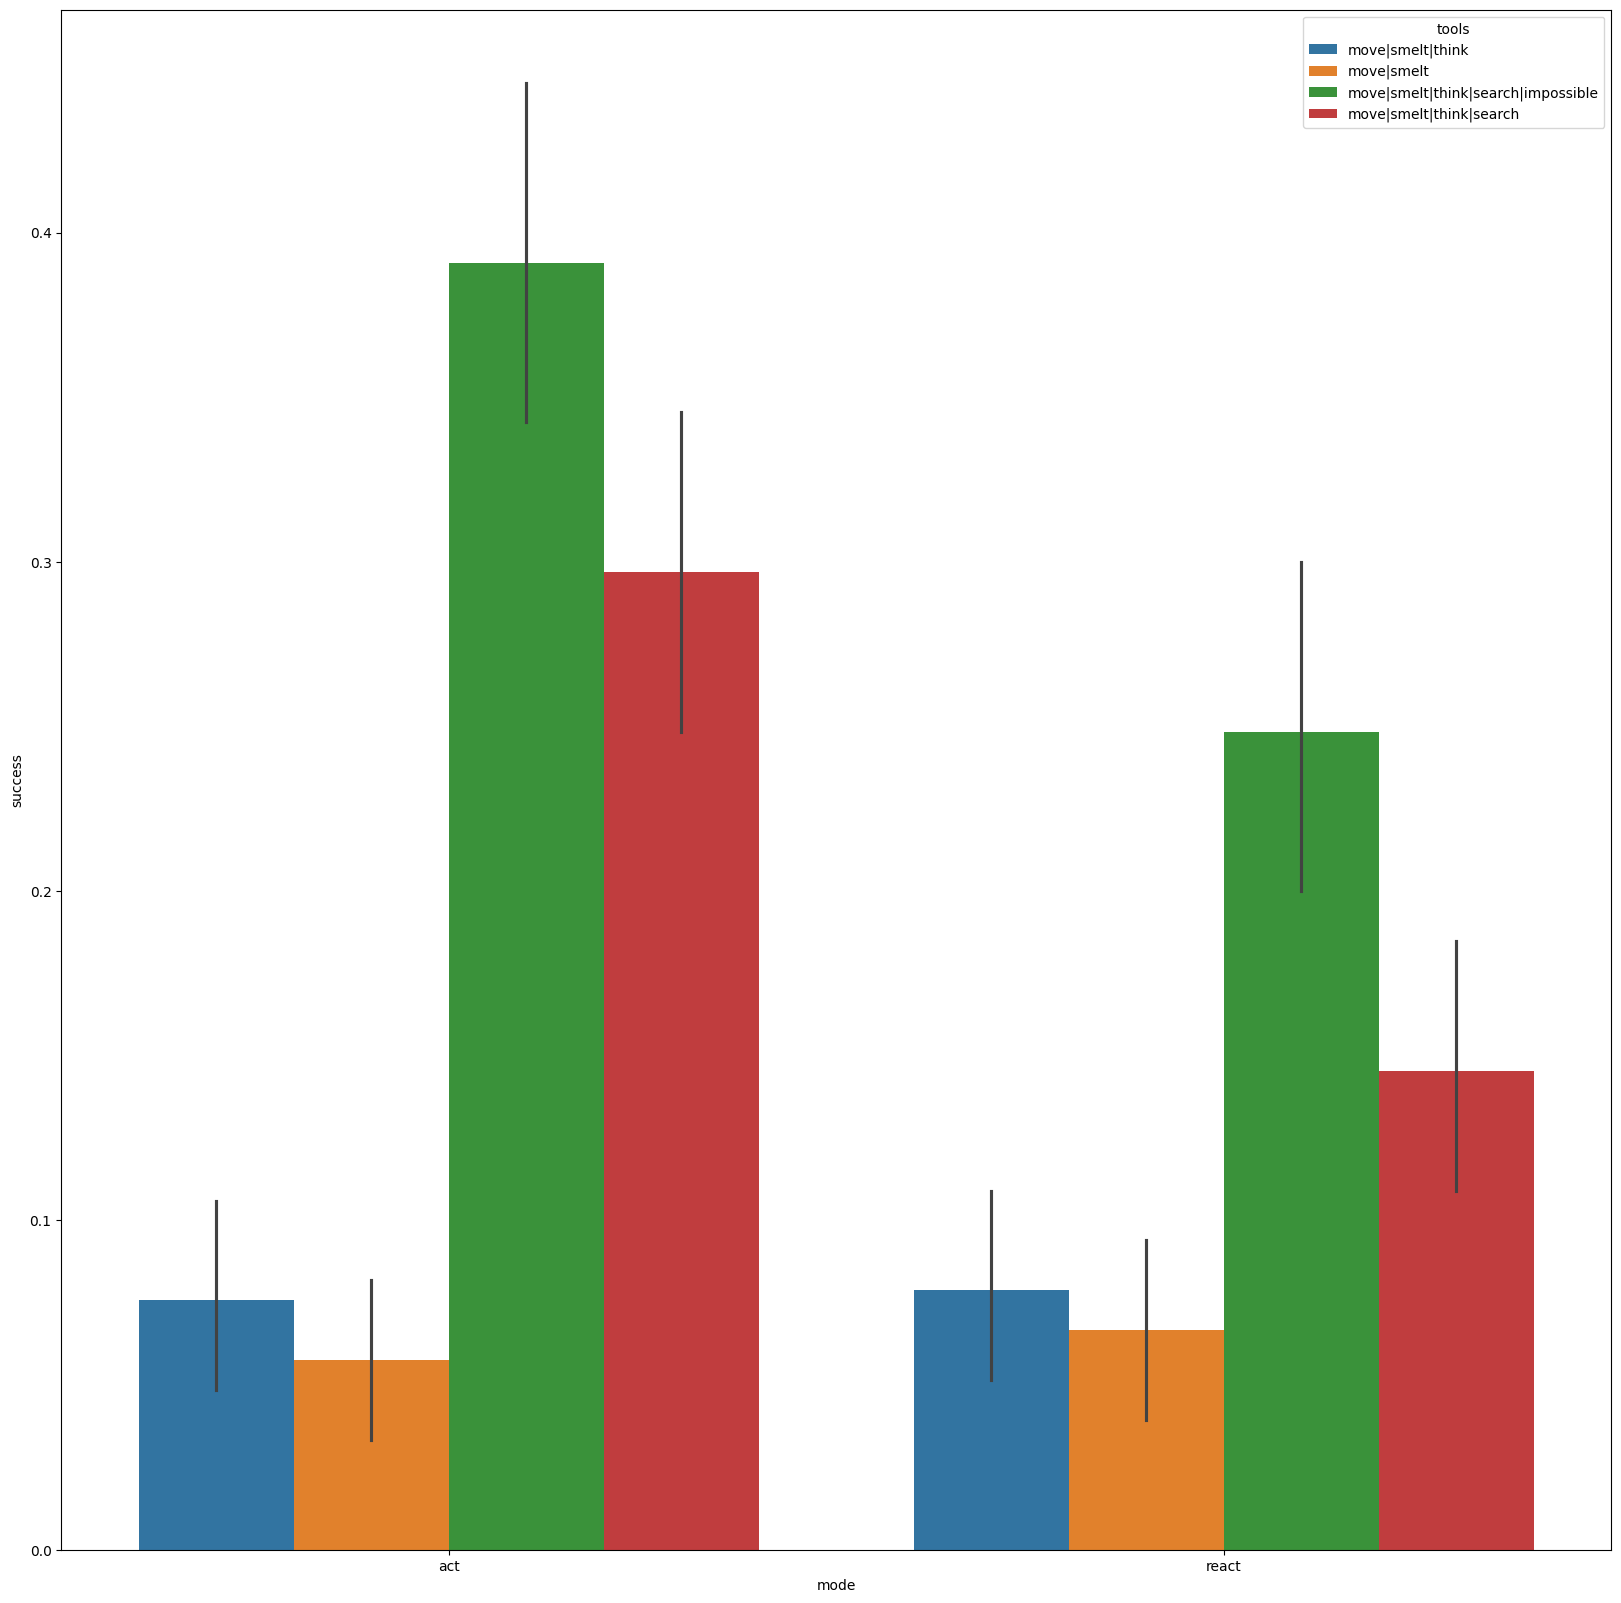

In [110]:
import seaborn as sns
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(20, 20))
sns.barplot(data=df, x="mode", y="success", hue="tools")
# rotate x labels
# plt.xticks(rotation=45)
plt.show()
